In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Week 11 - Event Study With Value, Derivative, and Second Derivative

## Question 1

In [ ]:
def generate_complex_event_data(n_periods=200, event_time=100):

    # Generate data where value, derivative, and second derivative all change at event
    # Pre-event: y = 10 + 0.5*t + 0.01*t² + noise
    # Post-event: y = 15 + 1.2*t + 0.005*t² + noise

    # Changes:
    # - Value: jumps by 5 units
    # - Derivative: changes from 0.5 to 1.2 (becomes steeper)
    # - Second derivative: changes from 0.01 to 0.005 (curvature decreases)

    time = np.arange(1, n_periods + 1)
    post_event = (time > event_time).astype(int)
    
    # Create the complex trend with discontinuities
    y_base = np.where(
        time <= event_time,
        10 + 0.5 * time + 0.01 * time**2,  # Pre-event trend
        15 + 1.2 * time + 0.005 * time**2  # Post-event trend
    )
    
    # Add noise
    noise = np.random.normal(0, 2, n_periods)
    y = y_base + noise
    
    return pd.DataFrame({
        'time': time,
        'y': y,
        'post_event': post_event,
        'y_true': y_base  # True values without noise for comparison
    })

# Generate the dataset
df_complex = generate_complex_event_data()
event_time = 100

print(f"Dataset created with {len(df_complex)} observations")
print(f"Event occurs at time {event_time}")
print(f"Pre-event sample: {sum(df_complex['post_event'] == 0)} observations")
print(f"Post-event sample: {sum(df_complex['post_event'] == 1)} observations")

Dataset created with 200 observations
Event occurs at time 100
Pre-event sample: 100 observations
Post-event sample: 100 observations


### Value Only

In [4]:
def fit_simple_event_model(df):
    # Simple model: y = α + β₁*time + β₂*post_event + ε
    
    X = pd.DataFrame({
        'const': 1,
        'time': df['time'],
        'post_event': df['post_event']
    })
    
    model = sm.OLS(df['y'], X).fit()
    return model

model_a = fit_simple_event_model(df_complex)

print("Model A Results:")
print(f"Event Effect (value jump): {model_a.params['post_event']:.3f}")
print(f"Standard Error: {model_a.bse['post_event']:.3f}")
print(f"P-value: {model_a.pvalues['post_event']:.4f}")
print(f"R-squared: {model_a.rsquared:.4f}")

Model A Results:
Event Effect (value jump): 33.275
Standard Error: 5.213
P-value: 0.0000
R-squared: 0.9823


### Value With Derivatives

In [5]:
def fit_comprehensive_event_model(df):
    
    # Comprehensive model allowing for changes in value, slope, and curvature:
    # y = α + β₁*time + β₂*time² + β₃*post_event + β₄*(post_event*time) + β₅*(post_event*time²) + ε
    
    # Where:
    # - β₃ = immediate value change
    # - β₄ = change in linear trend (derivative change)
    # - β₅ = change in quadratic trend (second derivative change)
    
    X = pd.DataFrame({
        'const': 1,
        'time': df['time'],
        'time_sq': df['time']**2,
        'post_event': df['post_event'],
        'post_time': df['post_event'] * df['time'],
        'post_time_sq': df['post_event'] * df['time']**2
    })
    
    model = sm.OLS(df['y'], X).fit()
    return model

model_b = fit_comprehensive_event_model(df_complex)

print("Model B Results:")
print(f"Event Effect (value jump): {model_b.params['post_event']:.3f}")
print(f"Derivative Change: {model_b.params['post_time']:.3f}")
print(f"Second Derivative Change: {model_b.params['post_time_sq']:.6f}")
print(f"R-squared: {model_b.rsquared:.4f}")

# Model comparison
print(f"\nMODEL COMPARISON:")
print(f"Model A R²: {model_a.rsquared:.4f}")
print(f"Model B R²: {model_b.rsquared:.4f}")
print(f"Improvement: {model_b.rsquared - model_a.rsquared:.4f}")

# F-test for additional parameters
f_stat = ((model_b.ssr - model_a.ssr) / 2) / (model_a.ssr / (len(df_complex) - 6))
f_pvalue = 1 - stats.f.cdf(f_stat, 2, len(df_complex) - 6)
print(f"F-test for additional parameters: F = {f_stat:.3f}, p = {f_pvalue:.4f}")


Model B Results:
Event Effect (value jump): -0.193
Derivative Change: 0.785
Second Derivative Change: -0.005391
R-squared: 0.9998

MODEL COMPARISON:
Model A R²: 0.9823
Model B R²: 0.9998
Improvement: 0.0175
F-test for additional parameters: F = -96.012, p = 1.0000


### Visualization

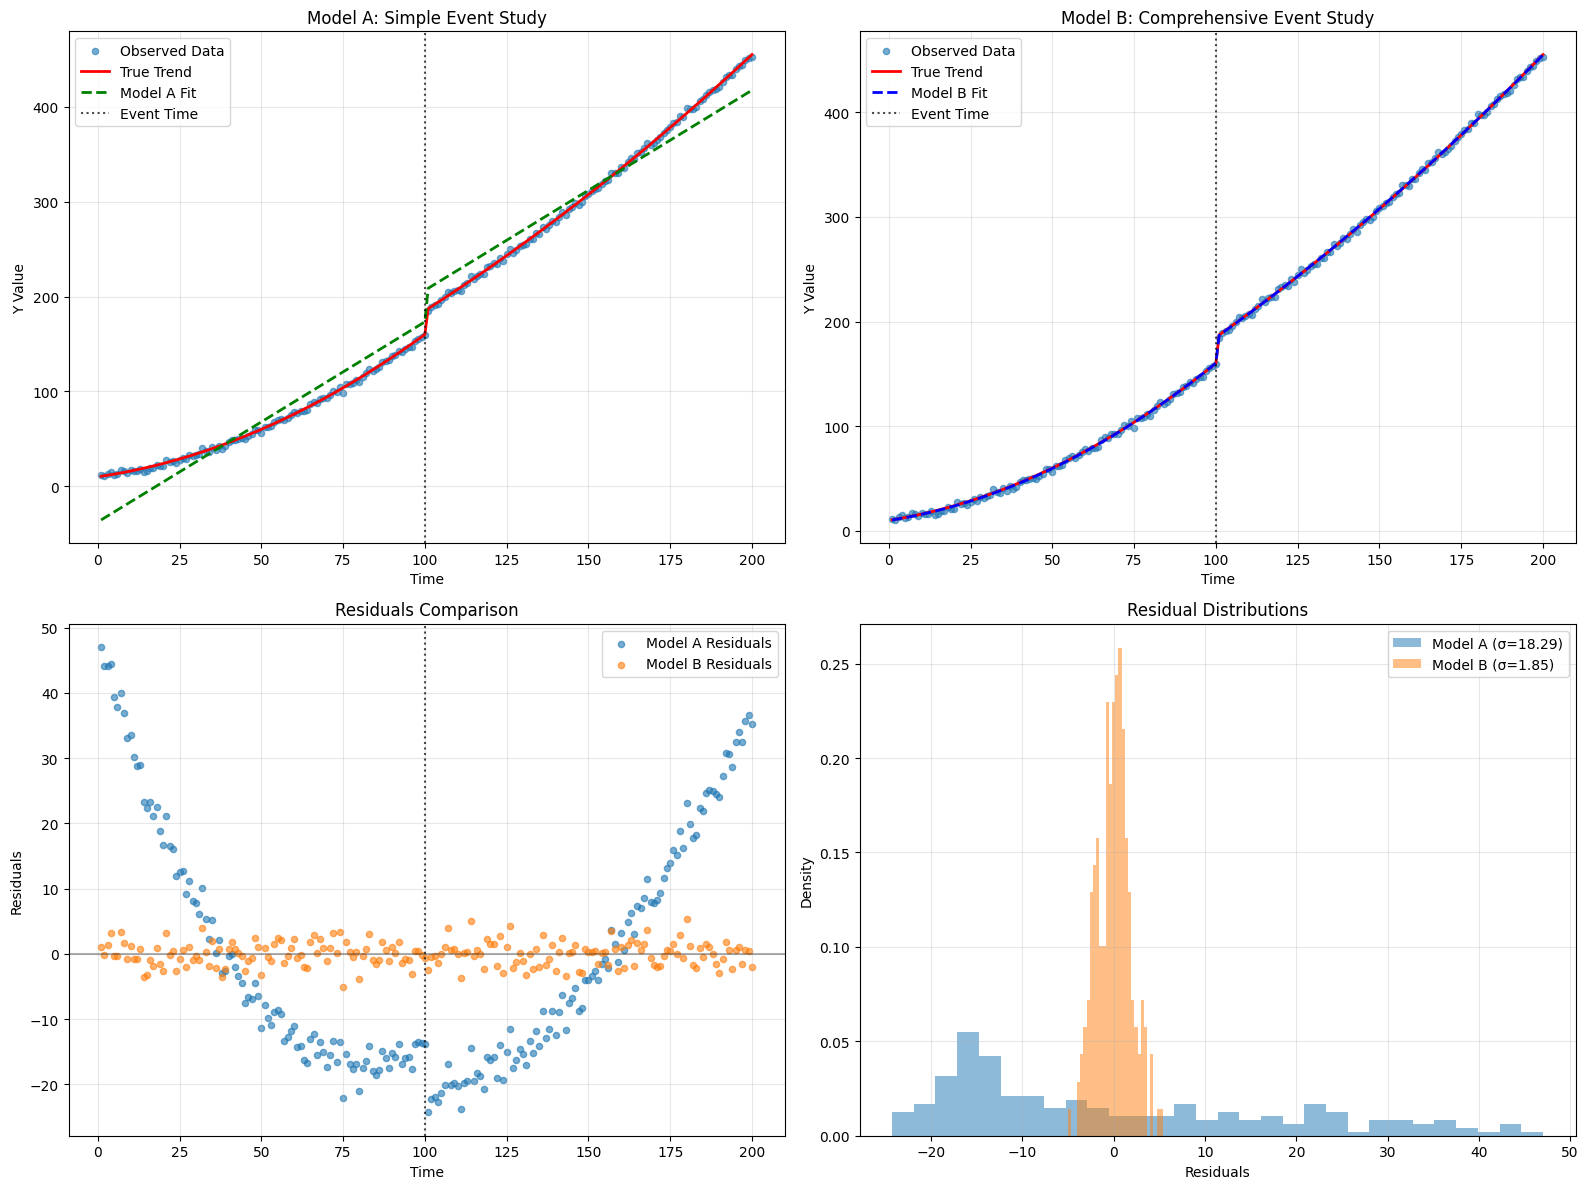

In [6]:
# Generate predictions
df_complex['pred_a'] = model_a.predict()
df_complex['pred_b'] = model_b.predict()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Data and Model A
ax1.scatter(df_complex['time'], df_complex['y'], alpha=0.6, s=20, label='Observed Data')
ax1.plot(df_complex['time'], df_complex['y_true'], 'r-', linewidth=2, label='True Trend')
ax1.plot(df_complex['time'], df_complex['pred_a'], 'g--', linewidth=2, label='Model A Fit')
ax1.axvline(x=event_time, color='black', linestyle=':', alpha=0.7, label='Event Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Y Value')
ax1.set_title('Model A: Simple Event Study')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Data and Model B
ax2.scatter(df_complex['time'], df_complex['y'], alpha=0.6, s=20, label='Observed Data')
ax2.plot(df_complex['time'], df_complex['y_true'], 'r-', linewidth=2, label='True Trend')
ax2.plot(df_complex['time'], df_complex['pred_b'], 'b--', linewidth=2, label='Model B Fit')
ax2.axvline(x=event_time, color='black', linestyle=':', alpha=0.7, label='Event Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Y Value')
ax2.set_title('Model B: Comprehensive Event Study')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals comparison
ax3.scatter(df_complex['time'], model_a.resid, alpha=0.6, s=20, label='Model A Residuals')
ax3.scatter(df_complex['time'], model_b.resid, alpha=0.6, s=20, label='Model B Residuals')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.axvline(x=event_time, color='black', linestyle=':', alpha=0.7)
ax3.set_xlabel('Time')
ax3.set_ylabel('Residuals')
ax3.set_title('Residuals Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Model diagnostics
residuals_a = model_a.resid
residuals_b = model_b.resid

ax4.hist(residuals_a, bins=30, alpha=0.5, label=f'Model A (σ={np.std(residuals_a):.2f})', density=True)
ax4.hist(residuals_b, bins=30, alpha=0.5, label=f'Model B (σ={np.std(residuals_b):.2f})', density=True)
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Density')
ax4.set_title('Residual Distributions')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Question 2

In [11]:
def generate_group_event_data(n_periods=150, n_groups=3, event_time=75):
    # Generate data for multiple groups with:
    # - Different baseline levels (group fixed effects)
    # - Parallel trends before event
    # - Same event effect for all groups
    
    # Group characteristics
    group_baselines = [10, 25, 40]  # Different starting levels
    group_names = ['Group_A', 'Group_B', 'Group_C']
    
    data = []
    
    for g, (baseline, group_name) in enumerate(zip(group_baselines, group_names)):
        for t in range(1, n_periods + 1):
            # Common time trend
            time_trend = 0.3 * t
            
            # Event effect (same for all groups)
            event_effect = 8 if t > event_time else 0
            
            # Generate y value
            y_true = baseline + time_trend + event_effect
            y_observed = y_true + np.random.normal(0, 1.5)
            
            data.append({
                'group': group_name,
                'group_id': g,
                'time': t,
                'post_event': 1 if t > event_time else 0,
                'y': y_observed,
                'y_true': y_true
            })
    
    return pd.DataFrame(data)

# Generate group data
df_groups = generate_group_event_data()

print(f"Group dataset created:")
print(f"- {len(df_groups)} total observations")
print(f"- {df_groups['group'].nunique()} groups")
print(f"- {df_groups['time'].nunique()} time periods")
print(f"- Event at time {df_groups[df_groups['post_event']==1]['time'].min()}")

# Show group baselines
print(f"\nGroup baseline levels:")
for group in df_groups['group'].unique():
    baseline = df_groups[(df_groups['group']==group) & (df_groups['time']==1)]['y'].iloc[0]
    print(f"  {group}: ~{baseline:.1f}")

Group dataset created:
- 450 total observations
- 3 groups
- 150 time periods
- Event at time 76

Group baseline levels:
  Group_A: ~13.1
  Group_B: ~26.7
  Group_C: ~39.9


## Group Fixed Effects Model

In [14]:
def fit_group_fixed_effects_model(df):
    # Model: y_it = α_i + β₁*time + β₂*post_event + ε_it
    
    # Where:
    # - α_i = group fixed effects (different intercepts)
    # - β₁ = common time trend
    # - β₂ = common event effect

    
    # Create dummy variables for groups (drop one for identification)
    group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True)
    
    # Create the design matrix with proper data types
    X = pd.DataFrame({
        'const': np.ones(len(df)),
        'time': df['time'].astype(float),  # Ensure numeric type
        'post_event': df['post_event'].astype(float)  # Ensure numeric type
    })
    
    # Add group dummies and ensure they're numeric
    for col in group_dummies.columns:
        X[col] = group_dummies[col].astype(float)
    
    # Ensure y is numeric
    y = df['y'].astype(float)
    
    model = sm.OLS(y, X).fit()
    return model

# Fit the model
group_model = fit_group_fixed_effects_model(df_groups)

print("Group Fixed Effects Model Results:")
print(f"Common Event Effect: {group_model.params['post_event']:.3f}")
print(f"Standard Error: {group_model.bse['post_event']:.3f}")
print(f"P-value: {group_model.pvalues['post_event']:.4f}")
print(f"Time Trend: {group_model.params['time']:.3f}")
print(f"R-squared: {group_model.rsquared:.4f}")

# Compare with pooled model (no group effects)
def fit_pooled_model(df):
    """Simple pooled model ignoring group differences"""
    X = pd.DataFrame({
        'const': 1,
        'time': df['time'],
        'post_event': df['post_event']
    })
    return sm.OLS(df['y'], X).fit()

pooled_model = fit_pooled_model(df_groups)

print(f"\nComparison with Pooled Model (no group effects):")
print(f"Fixed Effects R²: {group_model.rsquared:.4f}")
print(f"Pooled Model R²: {pooled_model.rsquared:.4f}")
print(f"Improvement from FE: {group_model.rsquared - pooled_model.rsquared:.4f}")


Group Fixed Effects Model Results:
Common Event Effect: 8.221
Standard Error: 0.273
P-value: 0.0000
Time Trend: 0.298
R-squared: 0.9951

Comparison with Pooled Model (no group effects):
Fixed Effects R²: 0.9951
Pooled Model R²: 0.6413
Improvement from FE: 0.3538


### Visualization

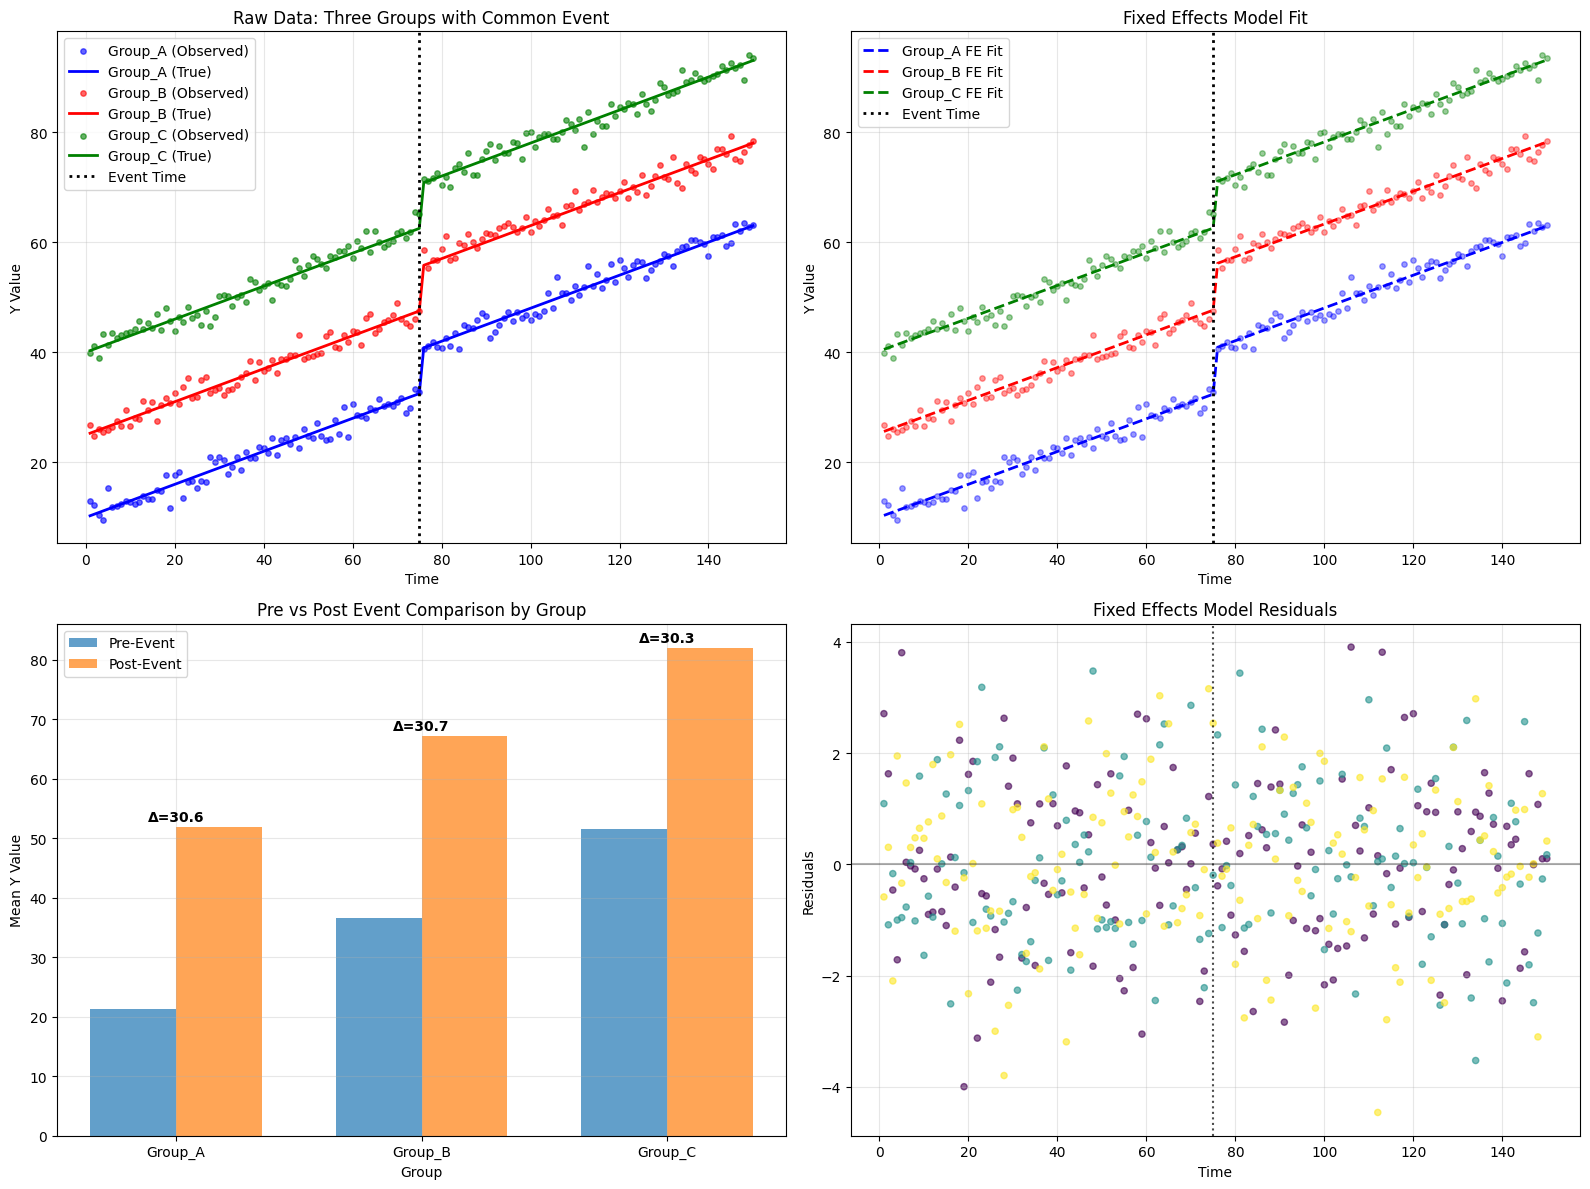

In [15]:
# Generate predictions
df_groups['pred_fe'] = group_model.predict()
df_groups['pred_pooled'] = pooled_model.predict()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Raw data by group
colors = ['blue', 'red', 'green']
for i, group in enumerate(df_groups['group'].unique()):
    group_data = df_groups[df_groups['group'] == group]
    ax1.scatter(group_data['time'], group_data['y'], alpha=0.6, 
               color=colors[i], label=f'{group} (Observed)', s=15)
    ax1.plot(group_data['time'], group_data['y_true'], 
            color=colors[i], linewidth=2, linestyle='-', label=f'{group} (True)')

ax1.axvline(x=75, color='black', linestyle=':', linewidth=2, label='Event Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Y Value')
ax1.set_title('Raw Data: Three Groups with Common Event')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Fixed effects model fit
for i, group in enumerate(df_groups['group'].unique()):
    group_data = df_groups[df_groups['group'] == group]
    ax2.scatter(group_data['time'], group_data['y'], alpha=0.4, 
               color=colors[i], s=15)
    ax2.plot(group_data['time'], group_data['pred_fe'], 
            color=colors[i], linewidth=2, linestyle='--', label=f'{group} FE Fit')

ax2.axvline(x=75, color='black', linestyle=':', linewidth=2, label='Event Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Y Value')
ax2.set_title('Fixed Effects Model Fit')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Comparison of event effects
pre_event = df_groups[df_groups['post_event'] == 0]
post_event = df_groups[df_groups['post_event'] == 1]

group_means_pre = pre_event.groupby('group')['y'].mean()
group_means_post = post_event.groupby('group')['y'].mean()

x_pos = np.arange(len(group_means_pre))
width = 0.35

ax3.bar(x_pos - width/2, group_means_pre, width, label='Pre-Event', alpha=0.7)
ax3.bar(x_pos + width/2, group_means_post, width, label='Post-Event', alpha=0.7)

ax3.set_xlabel('Group')
ax3.set_ylabel('Mean Y Value')
ax3.set_title('Pre vs Post Event Comparison by Group')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(group_means_pre.index)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add event effect annotations
for i, (pre, post) in enumerate(zip(group_means_pre, group_means_post)):
    effect = post - pre
    ax3.annotate(f'Δ={effect:.1f}', xy=(i, max(pre, post) + 1), 
                ha='center', fontweight='bold')

# Plot 4: Residual analysis
ax4.scatter(df_groups['time'], group_model.resid, alpha=0.6, 
           c=df_groups['group_id'], cmap='viridis', s=20)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.axvline(x=75, color='black', linestyle=':', alpha=0.7)
ax4.set_xlabel('Time')
ax4.set_ylabel('Residuals')
ax4.set_title('Fixed Effects Model Residuals')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()